# Kje naj danes kolesarim?
## Geografska analiza rekreativnega kolesarjenja v Sloveniji
---
Nekaj osnovnih vizualizacij in pregled podatkov (segments.json)

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon
import numpy as np
import geopandas as gpd
import mapclassify
from shapely.geometry import Point
import contextily as cx

In [48]:
with open("data/clean/segments.json", "r") as f:
    segments = json.load(f)

1. Nekaj osnovnih informacij 

In [49]:
# skupno število voženj na vseh segmentih
total_effort_count = sum(segment.get("effort_count", 0) for segment in segments)
print(f"Total effort count: {total_effort_count}")

# povprečno število voženj na segment
average_effort_count = total_effort_count / len(segments)
print(f"Average effort count: {average_effort_count}")

Total effort count: 14874530
Average effort count: 9747.398427260812


In [50]:
# top 10 segmentov po številu voženj
top_segments = sorted(segments, key=lambda x: x.get("effort_count", 0), reverse=True)[:10]
top_segments_df = pd.DataFrame(top_segments)
top_segments_df = top_segments_df[["name", "effort_count"]]
top_segments_df.columns = ["Segment Name", "Effort Count"]
top_segments_df.reset_index(drop=True, inplace=True)
top_segments_df.index += 1
top_segments_df.index.name = "Rank"
print("\nTop 10 segments by effort count:")
print(top_segments_df.to_string(index=True))


Top 10 segments by effort count:
                           Segment Name  Effort Count
Rank                                                 
1                           Ruda sprint        128925
2                           Koper-Izola        124440
3                   Bercetov Leg opener         79026
4                    Dobrova - Zaklanec         74309
5                        Zbilje ravnina         69922
6                       Nadvoz v Vodice         69779
7                   Strappetto di Vencò         67604
8                  TRISPORT FINISH 2020         64978
9                      logo short slope         63584
10    Vodice dirka 2017 - prva četrtina         63055


Boxplot števila voženj za segment:

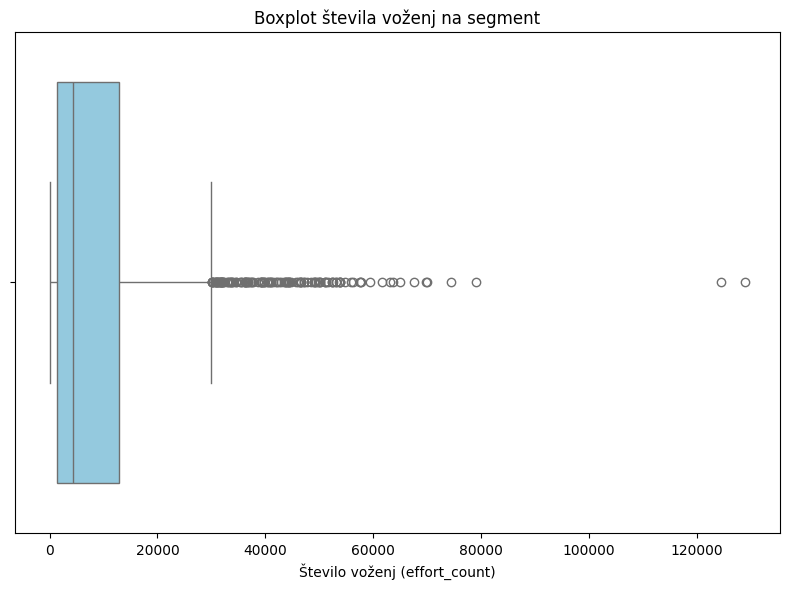

In [51]:
df = pd.read_json("data/clean/segments.json")

plt.figure(figsize=(8, 6))
sns.boxplot(x=df["effort_count"], color="skyblue")
plt.title("Boxplot števila voženj na segment")
plt.xlabel("Število voženj (effort_count)")
plt.tight_layout()
plt.savefig("data/plots/boxplot_effort_count.png")
plt.show()

2. Pregled in analiza "kolesarstva" glede na občine oz. regije.

In [52]:
# občine s številom segmentov
municipalities = {}
for segment in segments:
    municipality_list = segment.get("region")
    for municipality in municipality_list:
        municipalities[municipality] = municipalities.get(municipality, 0) + 1

municipalities_df = pd.DataFrame(list(municipalities.items()), columns=["Municipality", "Segment Count"])
municipalities_df.sort_values(by="Segment Count", ascending=False, inplace=True)
municipalities_df.reset_index(drop=True, inplace=True)
municipalities_df.index += 1
municipalities_df.index.name = "Rank"
print("\nMunicipalities with segment counts:")
print(municipalities_df.to_string(index=True))


Municipalities with segment counts:
                           Municipality  Segment Count
Rank                                                  
1                               Kocevje             51
2                      Ilirska Bistrica             39
3                                Tolmin             38
4                                 Bovec             35
5                             Ljubljana             31
6                                Bohinj             30
7                                 Koper             29
8                            Novo Mesto             29
9                                 Krško             28
10                               Idrija             27
11                         Nova Goriška             26
12                   Slovenska Bistrica             26
13                             Cerknica             24
14                             Crnomelj             22
15                               Kamnik             22
16                          

Glede na način pridobivanja podatkov (10 top segmentov na izbranem območju) ne preseneča nekakšna odvisnost št. segmentov od velikosti občine. Bolj zanimive bodo verjetno vsota števila voženj na občino in povprečno število voženj na občino.

In [53]:
# vsota voženj po občinah
municipality_effort_counts = {}
for segment in segments:
    municipality_list = segment.get("region")
    effort_count = segment.get("effort_count", 0)
    for municipality in municipality_list:
        municipality_effort_counts[municipality] = municipality_effort_counts.get(municipality, 0) + effort_count

municipality_effort_counts_df = pd.DataFrame(list(municipality_effort_counts.items()), columns=["Municipality", "Total Effort Count"])
municipality_effort_counts_df.sort_values(by="Total Effort Count", ascending=False, inplace=True)
municipality_effort_counts_df.reset_index(drop=True, inplace=True)
municipality_effort_counts_df.index += 1
municipality_effort_counts_df.index.name = "Rank"
print("\nMunicipalities with total effort counts:")
print(municipality_effort_counts_df.to_string(index=True))


Municipalities with total effort counts:
                           Municipality  Total Effort Count
Rank                                                       
1                             Ljubljana             1033332
2                                 Koper              738828
3                                 Bovec              512133
4                         Kranjska Gora              451758
5                                Kamnik              438402
6                 Dobrova-Polhov Gradec              425878
7                               Medvode              403302
8                             Brezovica              397618
9                                 Izola              363438
10                           Novo Mesto              351151
11                    Šmarješke Toplice              307139
12                                   Ig              287403
13                Cerklje na Gorenjskem              264226
14                                Krško              26292

Dokaj pričakovan obrat, najbolj prevožene so občine:
- Ljubljana (glavno mesto, velika zgoščenost ljudi)
- občine poznane po športnem turizmu (Bovec, Kranjska Gora, tudi Koper, Izola npr.)
- občine v bližini teh (dolžina povprečne kolesarske ture velikokrat presega le eno samo občino)

In [54]:
# avg. število voženj na segment po občinah
municipality_avg_effort_counts = {}
for segment in segments:
    municipality_list = segment.get("region")
    effort_count = segment.get("effort_count", 0)
    for municipality in municipality_list:
        if municipality not in municipality_avg_effort_counts:
            municipality_avg_effort_counts[municipality] = {"total_effort": 0, "segment_count": 0}
        municipality_avg_effort_counts[municipality]["total_effort"] += effort_count
        municipality_avg_effort_counts[municipality]["segment_count"] += 1

municipality_avg_effort_counts_df = pd.DataFrame.from_dict(municipality_avg_effort_counts, orient="index")
municipality_avg_effort_counts_df.reset_index(inplace=True)
municipality_avg_effort_counts_df.columns = ["Municipality", "Total Effort Count", "Segment Count"]
municipality_avg_effort_counts_df["Average Effort Count"] = municipality_avg_effort_counts_df["Total Effort Count"] / municipality_avg_effort_counts_df["Segment Count"]
municipality_avg_effort_counts_df.sort_values(by="Average Effort Count", ascending=False, inplace=True)
municipality_avg_effort_counts_df.reset_index(drop=True, inplace=True)
municipality_avg_effort_counts_df.index += 1
municipality_avg_effort_counts_df.index.name = "Rank"
print("\nMunicipalities with average effort counts:")
print(municipality_avg_effort_counts_df[["Municipality", "Average Effort Count", "Total Effort Count", "Segment Count"]].to_string(index=True))


Municipalities with average effort counts:
                           Municipality  Average Effort Count  Total Effort Count  Segment Count
Rank                                                                                            
1                                Vodice          66417.000000              132834              2
2                               Komenda          55821.500000              111643              2
3                     Šmarješke Toplice          51189.833333              307139              6
4                                 Izola          45429.750000              363438              8
5                             Žirovnica          43099.000000               86198              2
6                                 Naklo          42284.333333              126853              3
7                                Šenčur          41276.000000               82552              2
8                               Medvode          36663.818182              403302  

Zanimivo sosednji "majhni" občini Vodice in Komenda na tako visokem mestu, dodatne informacije o segmentih teh dveh občin:

In [55]:
# izpis segmentov iz občine Vodice in Komenda
vodice_segments = [segment for segment in segments if "Vodice" in segment.get("region", [])]
komenda_segments = [segment for segment in segments if "Komenda" in segment.get("region", [])]

print("\nSegments in Vodice:")
for segment in vodice_segments:
    print(f"- {segment['name']} ({segment['effort_count']})")

print("\nSegments in Komenda:")
for segment in komenda_segments:
    print(f"- {segment['name']} ({segment['effort_count']})")


Segments in Vodice:
- Vodice dirka 2017 - prva četrtina (63055)
- Nadvoz v Vodice (69779)

Segments in Komenda:
- TRISPORT FINISH 2020 (64978)
- Kamnik-Podgorje (46665)


Poglejmo histogram porazdelitve povprečnega števila voženj na segment v občini:

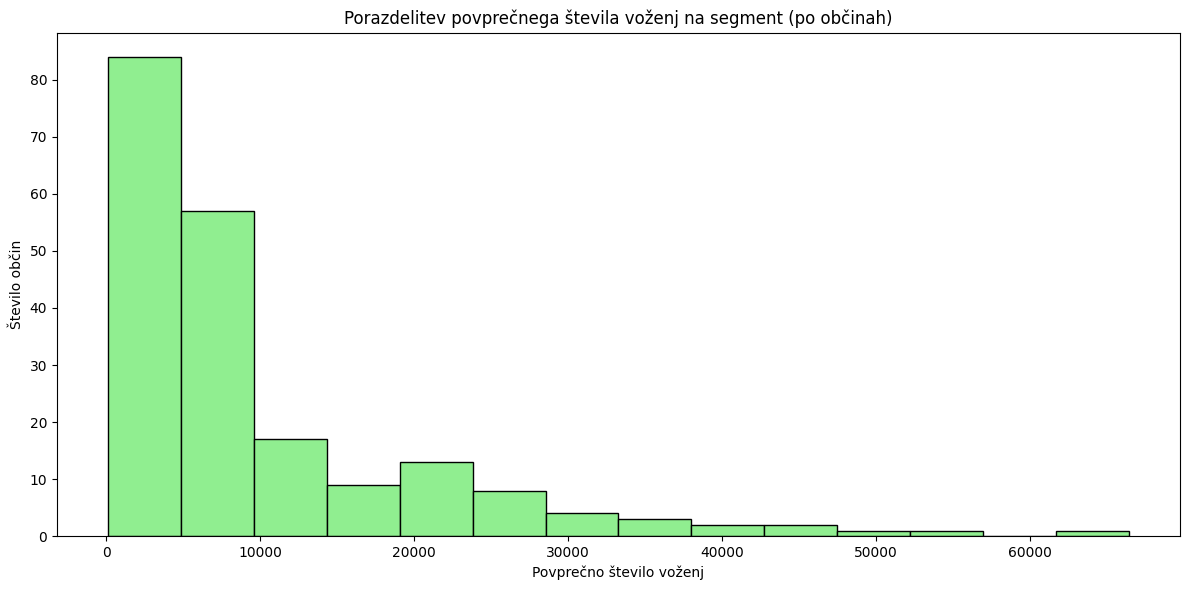

In [56]:
plt.figure(figsize=(12, 6))
plt.hist(municipality_avg_effort_counts_df["Average Effort Count"], bins=14, color="lightgreen", edgecolor="black")
plt.title("Porazdelitev povprečnega števila voženj na segment (po občinah)")
plt.xlabel("Povprečno število voženj")
plt.ylabel("Število občin")
plt.tight_layout()
plt.show()

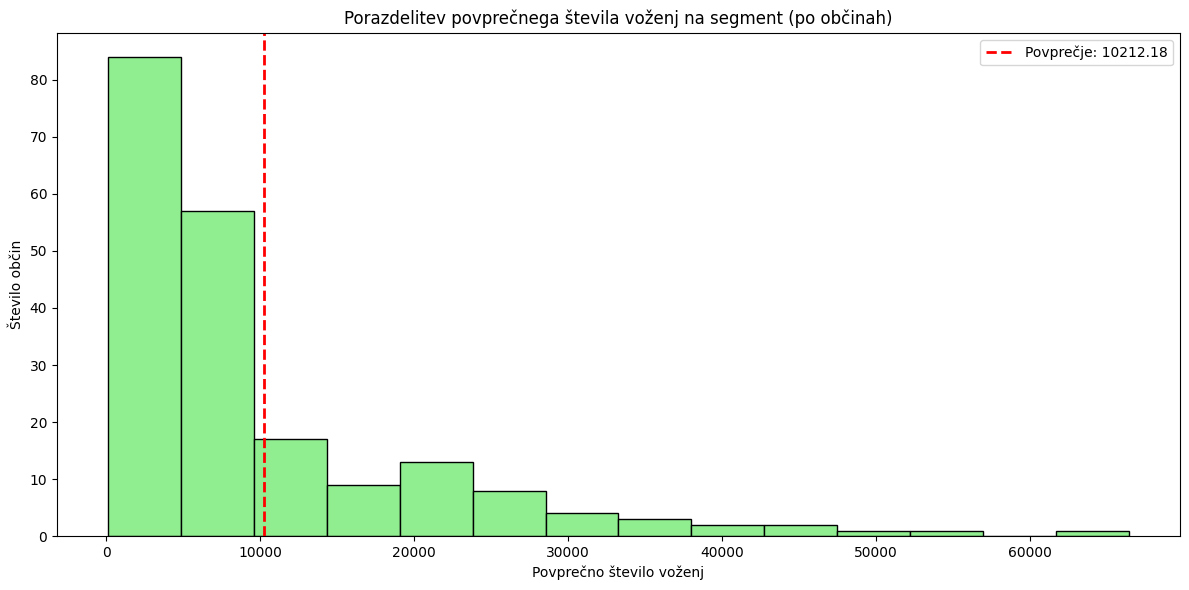

In [57]:
avg = municipality_avg_effort_counts_df["Average Effort Count"].mean()

plt.figure(figsize=(12, 6))
plt.hist(municipality_avg_effort_counts_df["Average Effort Count"], bins=14, color="lightgreen", edgecolor="black")

# črta povprečje
plt.axvline(avg, color='red', linestyle='dashed', linewidth=2, label=f"Povprečje: {avg:.2f}")

plt.title("Porazdelitev povprečnega števila voženj na segment (po občinah)")
plt.xlabel("Povprečno število voženj")
plt.ylabel("Število občin")
plt.legend()
plt.tight_layout()
plt.savefig("data/plots/histogram_avg_effort_count.png")
plt.show()


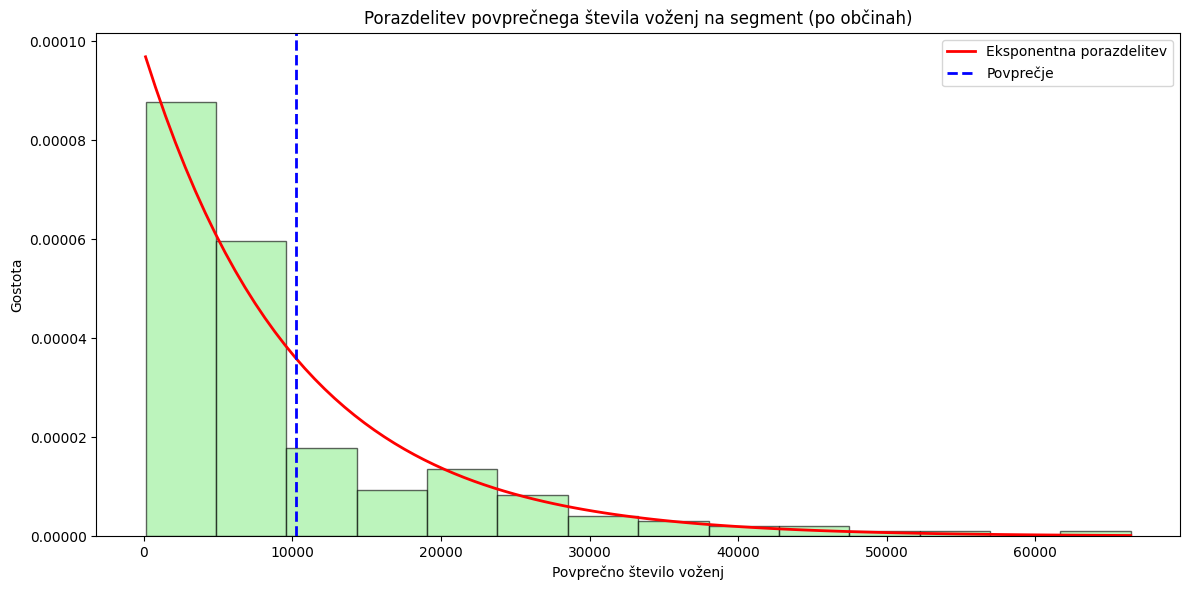

In [58]:
# samo preizkušanje

data = municipality_avg_effort_counts_df["Average Effort Count"]

loc, scale = expon.fit(data, floc=0)

plt.figure(figsize=(12, 6))
plt.hist(data, bins=14, density=True, color='lightgreen', edgecolor='black', alpha=0.6)

x = np.linspace(data.min(), data.max(), 100)
pdf = expon.pdf(x, loc, scale)
plt.plot(x, pdf, 'r-', lw=2, label='Eksponentna porazdelitev')

plt.axvline(data.mean(), color='blue', linestyle='--', linewidth=2, label='Povprečje')

plt.title("Porazdelitev povprečnega števila voženj na segment (po občinah)")
plt.xlabel("Povprečno število voženj")
plt.ylabel("Gostota")
plt.legend()
plt.tight_layout()
plt.savefig("data/plots/effort_count_exponential_fit.png")
plt.show()

Pričakovan trend padanja. Na pogled eksponentno.

Še preizkus lepe vizualizacije povprečnega števila voženj na segment po občinah v Sloveniji, kar nam nekako predstavlja `količino rekreativenga kolesarjenja` v občini, na zemljevidu Slovenije, z uporabo `geopandas` knjižnjice.

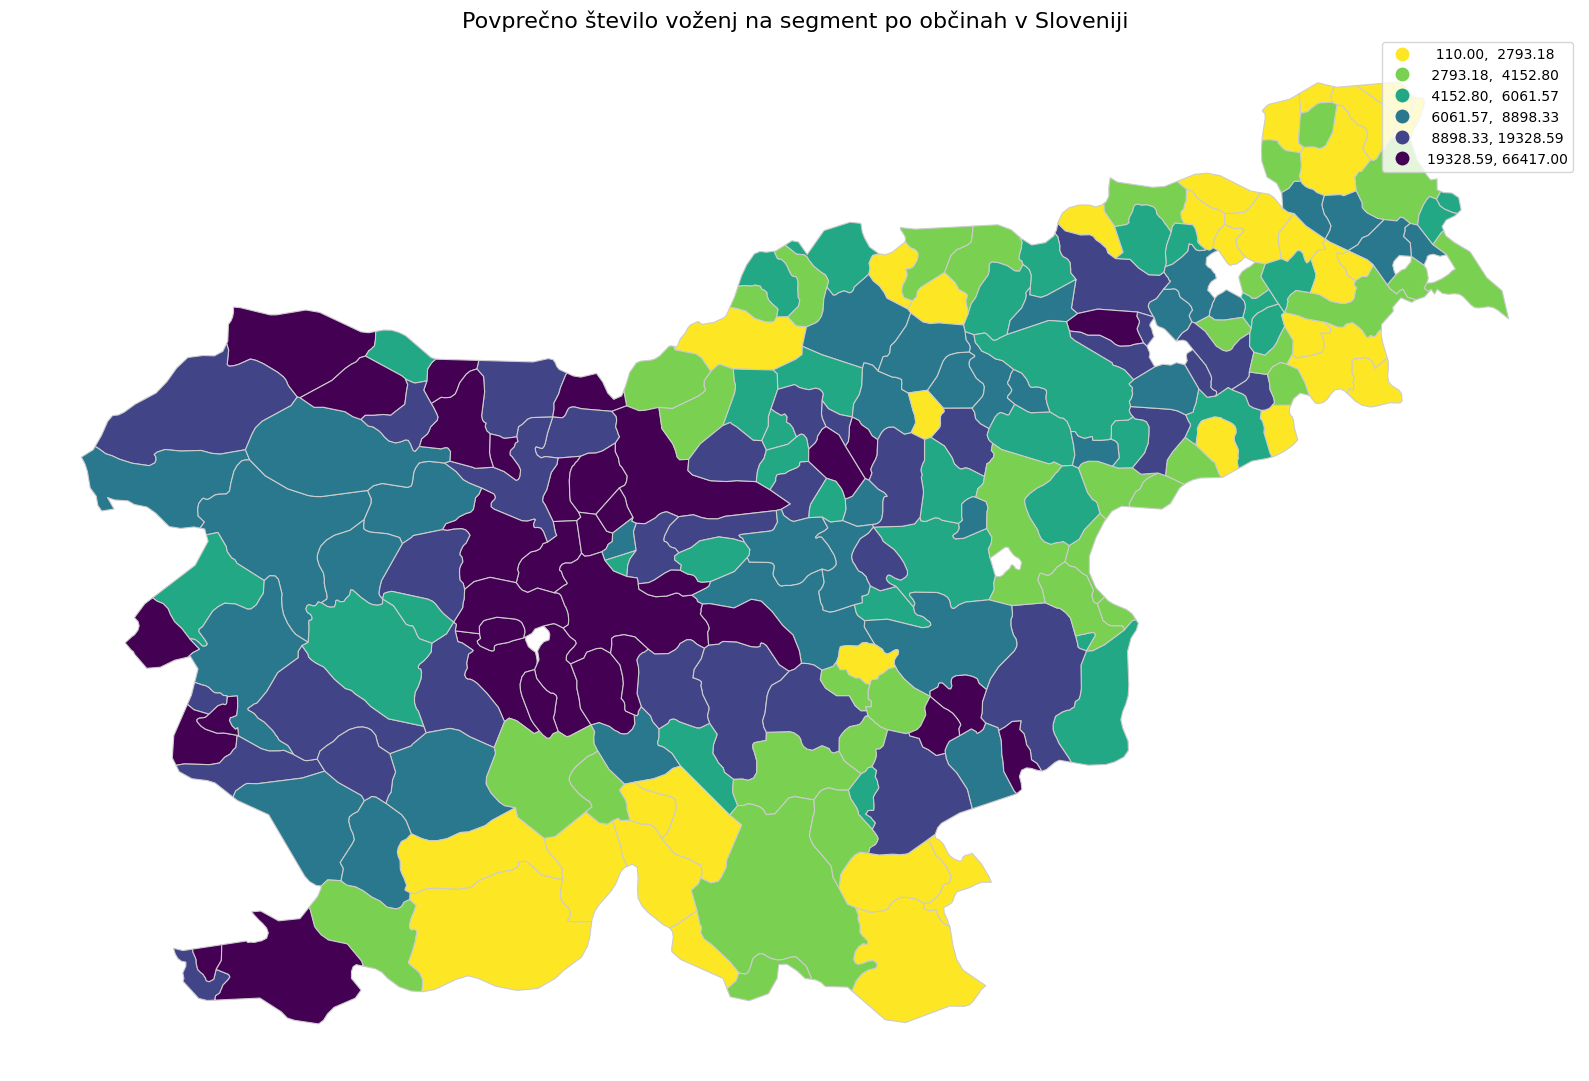

In [59]:
obcine_gdf = gpd.read_file("random/obcine.geojson")

merged = obcine_gdf.merge(municipality_avg_effort_counts_df, left_on="name", right_on="Municipality")

fig, ax = plt.subplots(figsize=(16, 12))
merged.plot(
    column="Average Effort Count",
    cmap="viridis_r",
    scheme="quantiles",
    k=6,
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
)

ax.set_title("Povprečno število voženj na segment po občinah v Sloveniji", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.savefig("data/plots/avg_effort_map_by_municipality.png")
plt.show()

Komentar: kot tudi videno že prej v celicah 9, 10 imamo 10 občin brez enega samega segmenta. Ali tam res ni Strava segmentov ali je to pomanjklivost metode ekstrakcije podatkov bomo naknadno ocenili in mogoče proces celega data_pipeline ponovili z natančnejšim prehodom Slovenije (več nivojsko; na najnižjem nivoju manjša področja z več prekrivanja).

---

3. Povezava med naklonom oz. kategorijo in vožnjami

In [60]:
# število voženj po kategorijah
categories = {}
for segment in segments:
    category = segment.get("custom_climb_category")
    if category is not None:
        categories[category] = categories.get(category, 0) + segment.get("effort_count", 0)

categories_df = pd.DataFrame(list(categories.items()), columns=["Category", "Effort Count"])
categories_df.sort_values(by="Effort Count", ascending=False, inplace=True)
categories_df.reset_index(drop=True, inplace=True)
categories_df.index += 1
categories_df.index.name = "Rank"
print("\nEffort counts by category:")
print(categories_df.to_string(index=True))



Effort counts by category:
      Category  Effort Count
Rank                        
1            0       5538783
2            1       5098670
3            2       2145880
4            3       1109909
5            4        719406
6            5        261882


In [61]:
# povprečno število voženj po kategorijah
categories_avg = {}
for segment in segments:
    category = segment.get("custom_climb_category")
    if category is not None:
        if category not in categories_avg:
            categories_avg[category] = {"total_effort": 0, "segment_count": 0}
        categories_avg[category]["total_effort"] += segment.get("effort_count", 0)
        categories_avg[category]["segment_count"] += 1

categories_avg_df = pd.DataFrame.from_dict(categories_avg, orient="index")
categories_avg_df.reset_index(inplace=True)
categories_avg_df.columns = ["Category", "Total Effort Count", "Segment Count"]
categories_avg_df["Average Effort Count"] = categories_avg_df["Total Effort Count"] / categories_avg_df["Segment Count"]
categories_avg_df.sort_values(by="Average Effort Count", ascending=False, inplace=True)
categories_avg_df.reset_index(drop=True, inplace=True)
categories_avg_df.index += 1
categories_avg_df.index.name = "Rank"
print("\nAverage effort counts by category:")
print(categories_avg_df[["Category", "Average Effort Count", "Total Effort Count", "Segment Count"]].to_string(index=True))


Average effort counts by category:
      Category  Average Effort Count  Total Effort Count  Segment Count
Rank                                                                   
1            1          12139.690476             5098670            420
2            0          11835.006410             5538783            468
3            2           7803.200000             2145880            275
4            4           6201.775862              719406            116
5            3           5691.841026             1109909            195
6            5           5036.192308              261882             52


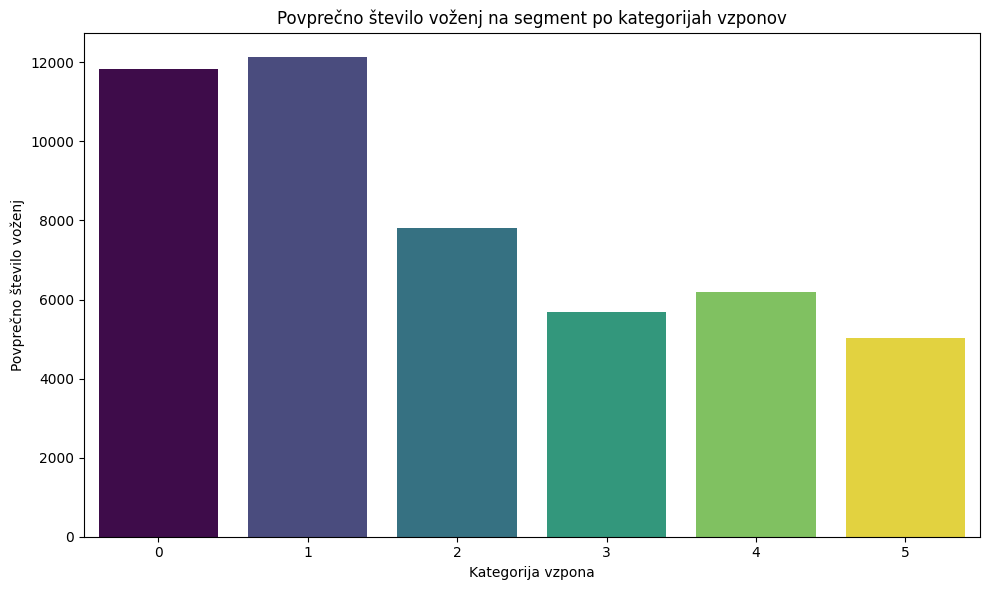

In [62]:
segments_df = pd.DataFrame(segments)

segments_df = segments_df[segments_df["custom_climb_category"].notnull()]

avg_effort_per_category = segments_df.groupby("custom_climb_category")["effort_count"].mean().reset_index()
avg_effort_per_category.columns = ["Category", "Average Effort Count"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_effort_per_category,
    x="Category",
    y="Average Effort Count",
    hue="Category",
    palette="viridis",
    legend=False
)
plt.title("Povprečno število voženj na segment po kategorijah vzponov")
plt.xlabel("Kategorija vzpona")
plt.ylabel("Povprečno število voženj")
plt.tight_layout()
plt.savefig("data/plots/avg_effort_per_category.png")
plt.show()

Ravninskih in 1. kategorije približno enako, nato padajoč trend, kategorijo smo nastavili sami glede na climb score. lahko bi še spreminjali.

In [66]:
top_by_category = segments_df.sort_values("effort_count", ascending=False).groupby("custom_climb_category").head(1)
print("Najbolj priljubljeni segmenti po kategorijah:")
print(top_by_category[["name", "custom_climb_category", "effort_count", "region"]].to_string(index=False))

Najbolj priljubljeni segmenti po kategorijah:
                   name  custom_climb_category  effort_count                  region
            Ruda sprint                      0        128925          [Izola, Koper]
    Bercetov Leg opener                      1         79026 [Dobrova-Polhov Gradec]
         Podutik prelaz                      2         54831             [Ljubljana]
Začetek vzpona na Vršič                      3         46533         [Kranjska Gora]
             Vzpon Nace                      4         44241           [Škofja Loka]
    Regular Climb Vrsic                      5         42966  [Kranjska Gora, Bovec]


In [67]:
# top 10 by climb_score
top_by_climb_score = segments_df.sort_values("climb_score", ascending=False).head(10)
print("\nTop 10 segmentov po climb_score:")
print(top_by_climb_score[["name", "climb_score", "region", "distance"]].to_string(index=False))


Top 10 segmentov po climb_score:
                                name  climb_score       region  distance
              Viševnik (1400m-2050m)   147.595600     [Bohinj]   2434.00
           Triglavska Cesta 91 Climb   142.838771     [Bohinj]   3019.36
                  trbovlje-kum climb   123.374790   [Trbovlje]   9385.86
Hotel Sola to Mangartsko sedlo Climb   116.699000      [Bovec]  10840.80
                      Dobrča classic   110.992800 [Radovljica]   8236.92
                       Vrisic Climb     96.632000      [Bovec]   8454.70
              Bovec to Mangart climb    94.794000      [Bovec]  24735.20
                          Stol Climb    85.740800    [Kobarid]  10106.90
          Ribjek - Strma Reber climb    78.109000   [Osilnica]   7407.20
                Kamp Triglav - Vršič    74.669000      [Bovec]  14518.00


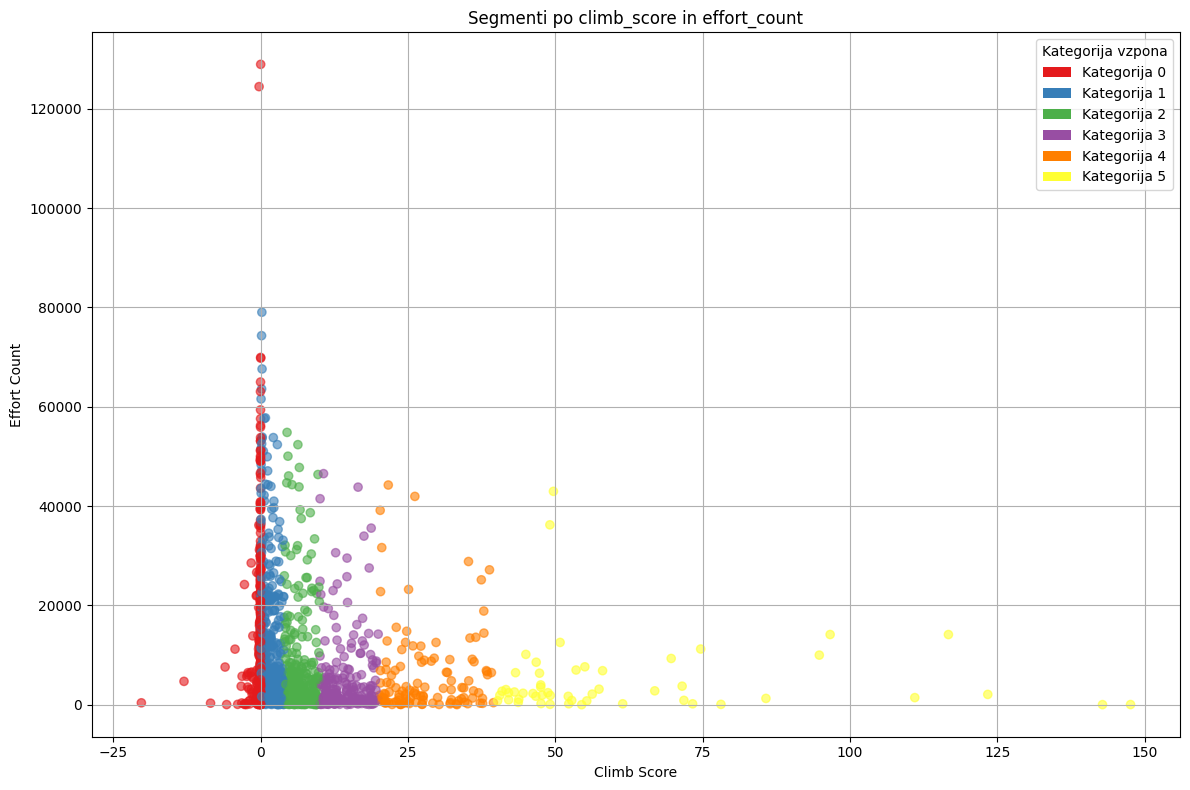

In [ ]:
# vizualizacija segmentov vožnje v odvisnosti od climb_score
palette = sns.color_palette("Set1", n_colors=6)  # ali "tab10", "Set2", ipd.
colors = segments_df["custom_climb_category"].map(lambda x: palette[x] if pd.notna(x) else (0.5, 0.5, 0.5))

plt.figure(figsize=(12, 8))
plt.scatter(
    segments_df["climb_score"],
    segments_df["effort_count"],
    c=colors,
    alpha=0.6
)

plt.title("Segmenti po climb_score in effort_count")
plt.xlabel("Climb Score")
plt.ylabel("Effort Count")
plt.grid(True)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=palette[i], label=f"Kategorija {i}")
    for i in range(6)
]
plt.legend(handles=legend_elements, title="Kategorija vzpona")

plt.tight_layout()
plt.savefig("data/plots/climb_score_vs_effort_count.png")
plt.show()

Vizualizacija segmentov s kategorijami na zemljevidu Slovenije:

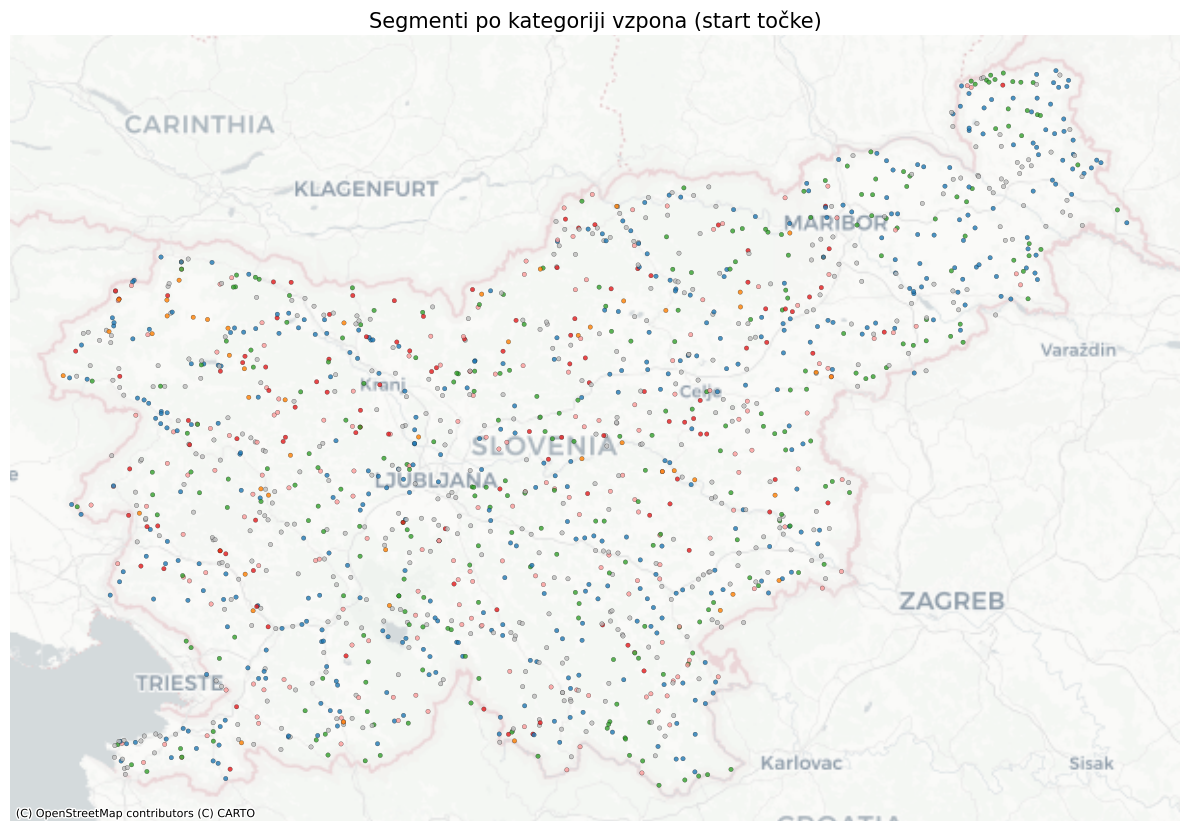

In [ ]:
df = pd.read_json("data/clean/segments.json")

df = df[df["start_latlng"].notna()]
df = df[df["custom_climb_category"].notna()]

df["geometry"] = df["start_latlng"].apply(lambda x: Point(x[1], x[0]))  # lon, lat
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf = gdf.to_crs(epsg=3857)

colors = {
    0: "#bdbdbd",
    1: "#1f78b4",
    2: "#33a02c",
    3: "#fb9a99",
    4: "#e31a1c",
    5: "#ff7f00"
}
gdf["color"] = gdf["custom_climb_category"].astype(int).map(colors)

fig, ax = plt.subplots(figsize=(12, 10))
gdf.plot(ax=ax, color=gdf["color"], markersize=10, alpha=0.8, edgecolor="black", linewidth=0.2)

cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
plt.title("Segmenti po kategoriji vzpona (start točke)", fontsize=15)
plt.tight_layout()

plt.savefig("data/plots/segments_map.png", dpi=200)
plt.show()


Ni kaj dosti razvidno, mogoče bi bilo bolje narediti nek heatmap kjer na širšem področju računamo neko povprečno kategorijo oz pojavnost visokokategornikov.